Stats 587
HW 2
Due 10/28/2025

In [1]:
# Import statements for all problems
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, t
from scipy.special import gamma as gamma_func
import seaborn as sns

## Problem 1
Write a Gibbs algorithm to simulate random samples from a joint density function $f(\beta, Z_1, ..., Z_{75}, \lambda_1, ..., \lambda_{75})$, where the fully conditioned distribution functions are:

• $\beta|Z_1, ..., Z_{75}, \lambda_1, ..., \lambda_{75} \sim N\left(\frac{\sum_{i=1}^{75} \lambda_i Z_i}{\sum_{i=1}^{75} \lambda_i}, \frac{1}{\sum_{i=1}^{75} \lambda_i}\right)$

• For $i = 1, ..., 50$: $Z_i|\beta, \lambda_1, ..., \lambda_{75} \sim$ left truncated normal at 0

• For $i = 51, ..., 75$: $Z_i|\beta, \lambda_1, ..., \lambda_{75} \sim$ right truncated normal at 0

• For $i = 1, ..., 75$: $\lambda_i|\beta, Z_1, ..., Z_{75} \sim \Gamma\left(\frac{5}{2}, \frac{2}{4 + (Z_i + \beta)^2}\right)$

### Problem 1a
Implement the Gibbs algorithm and plot the trace and density of: $\beta$, $Z_1$, $Z_{51}$, $\lambda_1$ (8 plots)

Running Gibbs sampler...
Generated 5000 samples
Beta stats: mean=0.1216, std=0.1613
Beta range: [-1.2763, 5.1247]
Generated 5000 samples
Beta stats: mean=0.1216, std=0.1613
Beta range: [-1.2763, 5.1247]


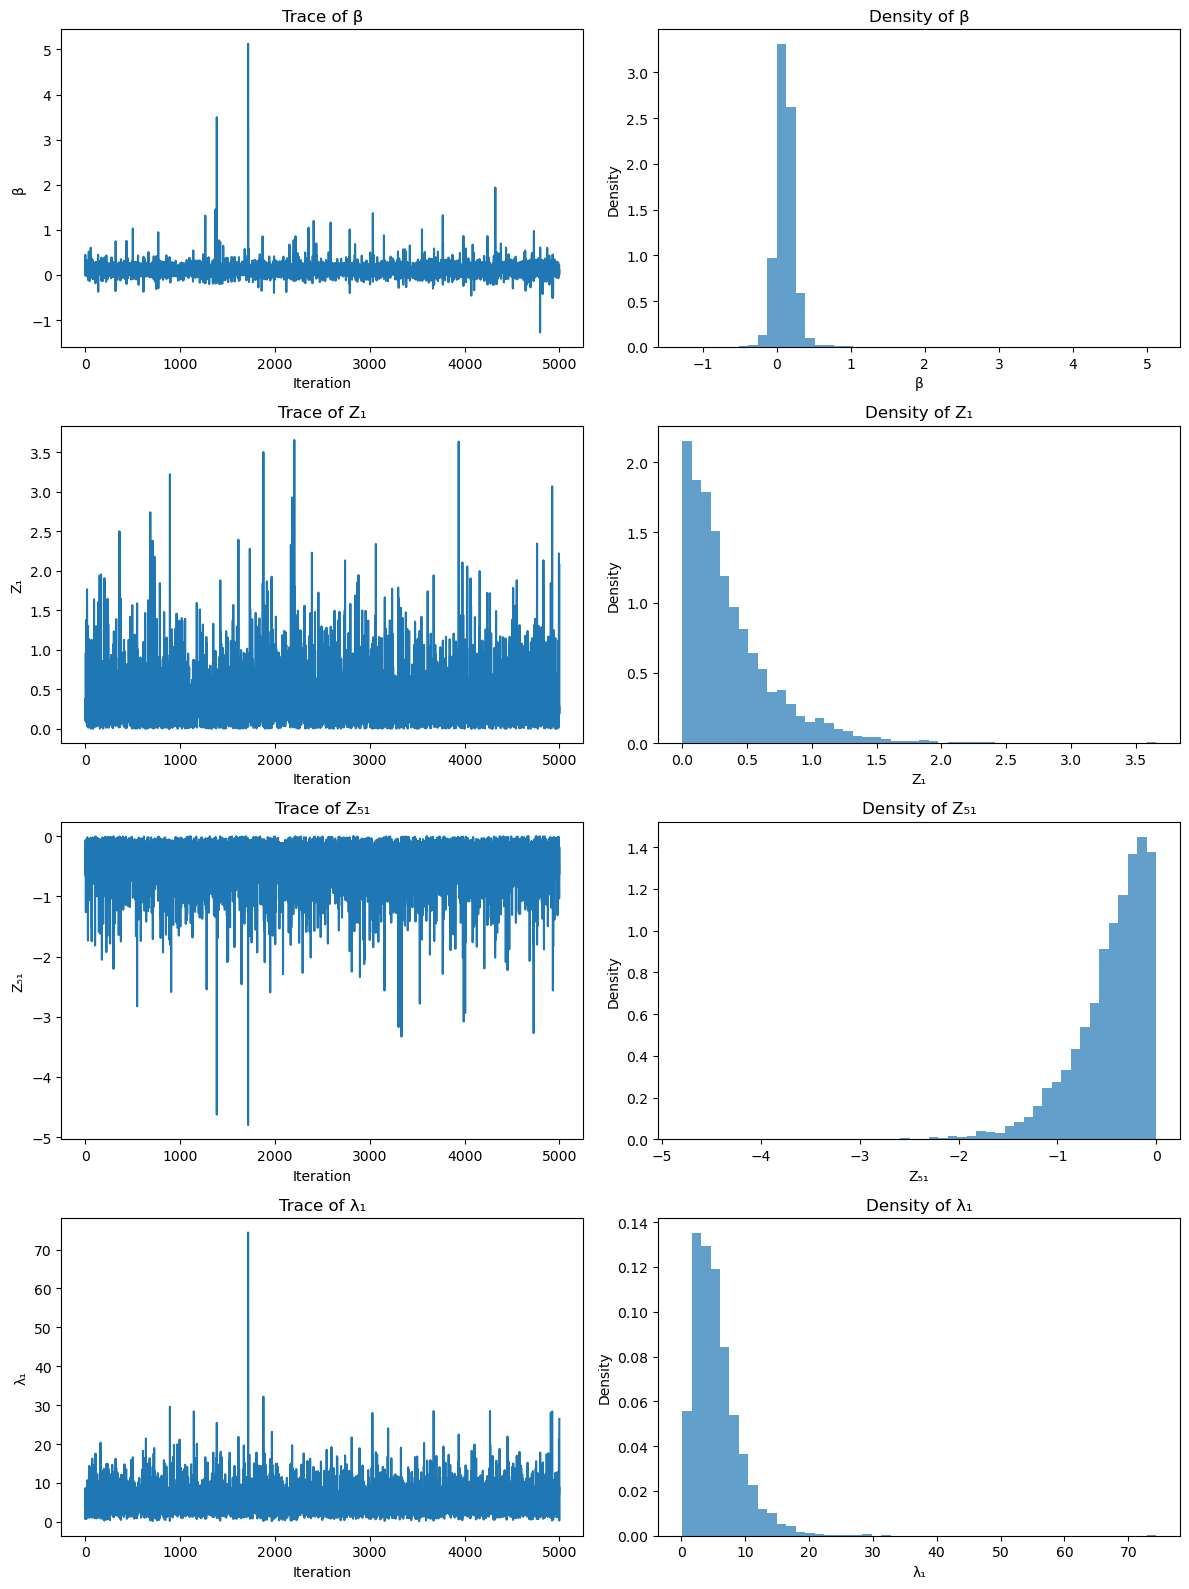

In [3]:
# Solution for Problem 1a - Gibbs Algorithm

def truncated_normal_sample(mu, sigma, lower=None, upper=None):
    """Sample from truncated normal distribution"""
    if lower is not None and upper is None:  # left truncated
        # Sample from N(mu, sigma^2) truncated at lower
        a = (lower - mu) / sigma
        u = np.random.uniform(0, 1)
        # Avoid numerical issues
        cdf_a = norm.cdf(a)
        if cdf_a >= 0.9999:  # Avoid numerical issues
            return lower + np.random.exponential(sigma)
        z = norm.ppf(cdf_a + u * (1 - cdf_a))
        return mu + sigma * z
    elif upper is not None and lower is None:  # right truncated
        # Sample from N(mu, sigma^2) truncated at upper
        b = (upper - mu) / sigma
        u = np.random.uniform(0, 1)
        # Avoid numerical issues
        cdf_b = norm.cdf(b)
        if cdf_b <= 0.0001:  # Avoid numerical issues
            return upper - np.random.exponential(sigma)
        z = norm.ppf(u * cdf_b)
        return mu + sigma * z
    else:
        return np.random.normal(mu, sigma)

def gibbs_sampler(n_iter=10000, burnin=1000):
    """Gibbs sampler for the joint distribution"""
    # Initialize with reasonable values
    beta = 0.0
    Z = np.random.normal(0, 0.1, 75)  # Small initial values
    # Initialize first 50 Z's to positive, last 25 to negative
    Z[:50] = np.abs(Z[:50])  
    Z[50:] = -np.abs(Z[50:])
    lam = np.ones(75)  # Initialize lambda to 1
    
    # Storage
    beta_samples = []
    Z_samples = []
    lam_samples = []
    
    for i in range(n_iter + burnin):
        # Update beta
        sum_lam = np.sum(lam)
        sum_lam_Z = np.sum(lam * Z)
        if sum_lam > 0:  # Avoid division by zero
            beta_mean = sum_lam_Z / sum_lam
            beta_var = 1.0 / sum_lam
            beta = np.random.normal(beta_mean, np.sqrt(beta_var))
        
        # Update Z_i
        for j in range(75):
            mu = -beta
            sigma = 1.0 / np.sqrt(lam[j])
            
            if j < 50:  # i = 1, ..., 50: left truncated at 0
                Z[j] = truncated_normal_sample(mu, sigma, lower=0)
            else:  # i = 51, ..., 75: right truncated at 0
                Z[j] = truncated_normal_sample(mu, sigma, upper=0)
        
        # Update lambda_i
        for j in range(75):
            shape = 5.0 / 2.0
            rate = 2.0 / (4.0 + (Z[j] + beta)**2)
            # Ensure rate is positive and finite
            rate = max(rate, 1e-10)
            lam[j] = np.random.gamma(shape, 1.0/rate)
        
        # Store samples after burnin
        if i >= burnin:
            beta_samples.append(beta)
            Z_samples.append(Z.copy())
            lam_samples.append(lam.copy())
    
    return np.array(beta_samples), np.array(Z_samples), np.array(lam_samples)

# Run Gibbs sampler
print("Running Gibbs sampler...")
beta_samples, Z_samples, lam_samples = gibbs_sampler(n_iter=5000, burnin=500)

print(f"Generated {len(beta_samples)} samples")
print(f"Beta stats: mean={np.mean(beta_samples):.4f}, std={np.std(beta_samples):.4f}")
print(f"Beta range: [{np.min(beta_samples):.4f}, {np.max(beta_samples):.4f}]")

# Check for any NaN or infinite values
if np.any(np.isnan(beta_samples)) or np.any(np.isinf(beta_samples)):
    print("Warning: NaN or infinite values detected in beta_samples")
    # Filter out bad values
    valid_idx = np.isfinite(beta_samples)
    beta_samples = beta_samples[valid_idx]
    Z_samples = Z_samples[valid_idx]
    lam_samples = lam_samples[valid_idx]
    print(f"Filtered to {len(beta_samples)} valid samples")

# Plot trace and density plots
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

# Beta
axes[0,0].plot(beta_samples)
axes[0,0].set_title('Trace of β')
axes[0,0].set_xlabel('Iteration')
axes[0,0].set_ylabel('β')

axes[0,1].hist(beta_samples, bins=50, density=True, alpha=0.7)
axes[0,1].set_title('Density of β')
axes[0,1].set_xlabel('β')
axes[0,1].set_ylabel('Density')

# Z_1
Z1_samples = Z_samples[:, 0]
axes[1,0].plot(Z1_samples)
axes[1,0].set_title('Trace of Z₁')
axes[1,0].set_xlabel('Iteration')
axes[1,0].set_ylabel('Z₁')

axes[1,1].hist(Z1_samples, bins=50, density=True, alpha=0.7)
axes[1,1].set_title('Density of Z₁')
axes[1,1].set_xlabel('Z₁')
axes[1,1].set_ylabel('Density')

# Z_51
Z51_samples = Z_samples[:, 50]
axes[2,0].plot(Z51_samples)
axes[2,0].set_title('Trace of Z₅₁')
axes[2,0].set_xlabel('Iteration')
axes[2,0].set_ylabel('Z₅₁')

axes[2,1].hist(Z51_samples, bins=50, density=True, alpha=0.7)
axes[2,1].set_title('Density of Z₅₁')
axes[2,1].set_xlabel('Z₅₁')
axes[2,1].set_ylabel('Density')

# Lambda_1
lam1_samples = lam_samples[:, 0]
axes[3,0].plot(lam1_samples)
axes[3,0].set_title('Trace of λ₁')
axes[3,0].set_xlabel('Iteration')
axes[3,0].set_ylabel('λ₁')

axes[3,1].hist(lam1_samples, bins=50, density=True, alpha=0.7)
axes[3,1].set_title('Density of λ₁')
axes[3,1].set_xlabel('λ₁')
axes[3,1].set_ylabel('Density')

plt.tight_layout()
plt.show()

### Problem 1b
Based on the Monte Carlo method, compute $\hat{F}(0.75) - \hat{F}(-0.2)$ using the formula:

$$\hat{f}(\beta) = \frac{1}{T} \sum_{t=1}^{T} f(\beta|Z_1^{(t)}, ..., Z_{75}^{(t)}, \lambda_1^{(t)}, ..., \lambda_{75}^{(t)})$$

Computing marginal densities...
F̂(0.75) - F̂(-0.2) = 0.987881
F̂(0.75) - F̂(-0.2) = 0.987881


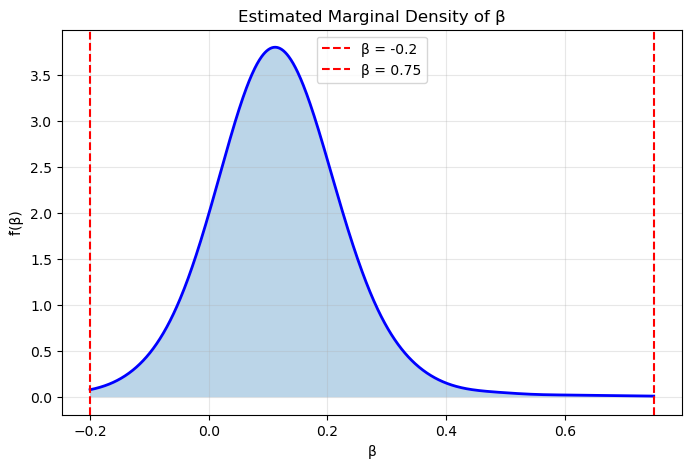

In [4]:
# Solution for Problem 1b - Marginal density estimation

def marginal_density_beta(beta_val, Z_samples, lam_samples):
    """Compute marginal density of beta at given value"""
    T = len(Z_samples)
    density_sum = 0.0
    
    for t in range(T):
        # f(beta | Z^(t), lambda^(t)) ~ N(mean, var)
        sum_lam = np.sum(lam_samples[t])
        sum_lam_Z = np.sum(lam_samples[t] * Z_samples[t])
        beta_mean = sum_lam_Z / sum_lam
        beta_var = 1.0 / sum_lam
        
        # Evaluate normal density
        density_sum += norm.pdf(beta_val, beta_mean, np.sqrt(beta_var))
    
    return density_sum / T

# Compute F_hat(0.75) - F_hat(-0.2) using numerical integration
beta_grid = np.linspace(-0.2, 0.75, 1000)
marginal_densities = []

print("Computing marginal densities...")
for beta_val in beta_grid:
    density = marginal_density_beta(beta_val, Z_samples, lam_samples)
    marginal_densities.append(density)

marginal_densities = np.array(marginal_densities)

# Numerical integration using trapezoidal rule
F_diff = np.trapz(marginal_densities, beta_grid)

print(f"F̂(0.75) - F̂(-0.2) = {F_diff:.6f}")

# Plot the marginal density
plt.figure(figsize=(8, 5))
plt.plot(beta_grid, marginal_densities, 'b-', linewidth=2)
plt.fill_between(beta_grid, marginal_densities, alpha=0.3)
plt.xlabel('β')
plt.ylabel('f̂(β)')
plt.title('Estimated Marginal Density of β')
plt.axvline(-0.2, color='r', linestyle='--', label='β = -0.2')
plt.axvline(0.75, color='r', linestyle='--', label='β = 0.75')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Problem 2
We want to estimate the integral $I = \int_{-\infty}^{\infty} x^3 p(x) dx$ where $p(x)$ is the pdf of $N(2,1)$.

### Problem 2a
Calculate the exact value of $I$.

In [ ]:
# Solution for Problem 2a - Exact calculation

# For X ~ N(μ, σ²), E[X³] = μ³ + 3μσ²
# Here μ = 2, σ² = 1
mu = 2
sigma_sq = 1

I_exact = mu**3 + 3*mu*sigma_sq
print(f"Exact value of I = E[X³] where X ~ N(2,1): {I_exact}")

# Alternative calculation: E[X³] = μ³ + 3μσ² = 2³ + 3(2)(1) = 8 + 6 = 14

### Problem 2b
Estimate $I$ using Monte-Carlo approximation with Metropolis-Hastings and different proposal distributions (n = 5000):

- $g(\cdot|x_t) = N(2,1)$
- $g(\cdot|x_t) = N(0,1)$
- $g(\cdot|x_t) = N(x_t, 1)$
- $g(\cdot|x_t) = N(x_t, 5)$

In [ ]:
# Solution for Problem 2b - Metropolis-Hastings with different proposals

def metropolis_hastings(n_samples, proposal_type, proposal_params):
    """
    Metropolis-Hastings sampler for N(2,1) distribution
    """
    samples = []
    current_x = 2.0  # Start at the mean
    n_accepted = 0
    
    for i in range(n_samples):
        # Generate proposal
        if proposal_type == "fixed_normal":
            # g(·|x_t) = N(μ, σ²)
            proposal = np.random.normal(proposal_params['mu'], proposal_params['sigma'])
        elif proposal_type == "random_walk":
            # g(·|x_t) = N(x_t, σ²)
            proposal = np.random.normal(current_x, proposal_params['sigma'])
        
        # Calculate acceptance probability
        # Since we're sampling from N(2,1), the target density is proportional to exp(-(x-2)²/2)
        log_target_current = -(current_x - 2)**2 / 2
        log_target_proposal = -(proposal - 2)**2 / 2
        
        # For symmetric proposals (random walk), the proposal ratio cancels out
        # For fixed proposals, we need to include the proposal ratio
        if proposal_type == "fixed_normal":
            log_proposal_ratio = (-(current_x - proposal_params['mu'])**2 / (2 * proposal_params['sigma']**2) + 
                                 (proposal - proposal_params['mu'])**2 / (2 * proposal_params['sigma']**2))
        else:
            log_proposal_ratio = 0  # Symmetric proposal
        
        log_alpha = min(0, log_target_proposal - log_target_current + log_proposal_ratio)
        alpha = np.exp(log_alpha)
        
        # Accept or reject
        if np.random.uniform() < alpha:
            current_x = proposal
            n_accepted += 1
        
        samples.append(current_x)
    
    acceptance_rate = n_accepted / n_samples
    return np.array(samples), acceptance_rate

# Different proposal distributions
proposals = [
    ("fixed_normal", {"mu": 2, "sigma": 1}, "N(2,1)"),
    ("fixed_normal", {"mu": 0, "sigma": 1}, "N(0,1)"),
    ("random_walk", {"sigma": 1}, "N(x_t, 1)"),
    ("random_walk", {"sigma": np.sqrt(5)}, "N(x_t, 5)")
]

n_samples = 5000
results = []

print("Metropolis-Hastings Results:")
print("="*60)

for prop_type, prop_params, prop_name in proposals:
    samples, acc_rate = metropolis_hastings(n_samples, prop_type, prop_params)
    
    # Estimate I = E[X³]
    I_estimate = np.mean(samples**3)
    
    results.append({
        'proposal': prop_name,
        'acceptance_rate': acc_rate,
        'I_estimate': I_estimate,
        'samples': samples
    })
    
    print(f"Proposal: {prop_name}")
    print(f"  Acceptance Rate: {acc_rate:.4f}")
    print(f"  I Estimate: {I_estimate:.4f}")
    print(f"  Error: {abs(I_estimate - I_exact):.4f}")
    print()

# Summary table
print("Summary:")
print(f"{'Proposal':<12} {'Acc. Rate':<10} {'I Estimate':<12} {'Error':<8}")
print("-" * 45)
for result in results:
    print(f"{result['proposal']:<12} {result['acceptance_rate']:<10.4f} {result['I_estimate']:<12.4f} {abs(result['I_estimate'] - I_exact):<8.4f}")

## Problem 3
Simulate bivariate copulas with correlation matrix $\begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix}$.

### Problem 3a
Write a program to simulate bivariate Gaussian copulas with correlation matrix $\begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix}$.

In [ ]:
# Solution for Problem 3a - Gaussian Copula

def simulate_gaussian_copula(n_samples, rho):
    """Simulate bivariate Gaussian copula"""
    # Correlation matrix
    Sigma = np.array([[1, rho], [rho, 1]])
    
    # Generate bivariate normal
    Z = np.random.multivariate_normal([0, 0], Sigma, n_samples)
    
    # Transform to uniform margins using CDF
    U = norm.cdf(Z)
    
    return U

# Test the function
rho_test = 0.5
U_test = simulate_gaussian_copula(1000, rho_test)
print(f"Gaussian copula with ρ = {rho_test}")
print(f"Sample correlations: {np.corrcoef(U_test.T)[0,1]:.4f}")
print(f"Marginal means: {np.mean(U_test, axis=0)}")
print(f"Shape: {U_test.shape}")

### Problem 3b
Write a program to simulate bivariate t-copulas with correlation matrix $\begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix}$ and $\nu$ degrees of freedom.

In [ ]:
# Solution for Problem 3b - t-Copula

def simulate_t_copula(n_samples, rho, nu):
    """Simulate bivariate t-copula"""
    # Correlation matrix
    Sigma = np.array([[1, rho], [rho, 1]])
    
    # Generate bivariate t-distribution
    # Method: Generate multivariate normal and chi-squared independently
    Z = np.random.multivariate_normal([0, 0], Sigma, n_samples)
    chi2 = np.random.chisquare(nu, n_samples)
    
    # Scale to get t-distribution
    T = Z * np.sqrt(nu / chi2[:, np.newaxis])
    
    # Transform to uniform margins using t-CDF
    U = t.cdf(T, nu)
    
    return U

# Test the function
rho_test = 0.5
nu_test = 3
U_test = simulate_t_copula(1000, rho_test, nu_test)
print(f"t-copula with ρ = {rho_test}, ν = {nu_test}")
print(f"Sample correlations: {np.corrcoef(U_test.T)[0,1]:.4f}")
print(f"Marginal means: {np.mean(U_test, axis=0)}")
print(f"Shape: {U_test.shape}")

### Problem 3c
Simulate 1000 samples and create scatter plots for:
- Gaussian copulas with ρ = 0.25 and ρ = 0.8
- t-copulas with (ρ = 0.25, ν = 3) and (ρ = 0.8, ν = 5)

Use marginal distribution N(0,1) for all cases (4 plots).

In [ ]:
# Solution for Problem 3c - Scatter plots

n_samples = 1000

# Parameters
params = [
    ("Gaussian", 0.25, None),
    ("Gaussian", 0.8, None),
    ("t", 0.25, 3),
    ("t", 0.8, 5)
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (copula_type, rho, nu) in enumerate(params):
    # Generate copula samples
    if copula_type == "Gaussian":
        U = simulate_gaussian_copula(n_samples, rho)
        title = f"Gaussian Copula (ρ = {rho})"
    else:  # t-copula
        U = simulate_t_copula(n_samples, rho, nu)
        title = f"t-Copula (ρ = {rho}, ν = {nu})"
    
    # Transform to N(0,1) margins
    X = norm.ppf(U)
    
    # Create scatter plot
    axes[i].scatter(X[:, 0], X[:, 1], alpha=0.6, s=20)
    axes[i].set_xlabel('X₁')
    axes[i].set_ylabel('X₂')
    axes[i].set_title(title)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_aspect('equal')
    
    # Add correlation info
    corr = np.corrcoef(X.T)[0, 1]
    axes[i].text(0.05, 0.95, f'Sample correlation: {corr:.3f}', 
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## Problem 4
Pump failure data analysis using Bayesian hierarchical model.

Given data for 10 power plant pumps with failure counts $Y_i$ and operation times $t_i$:

| Pump i | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|--------|---|---|---|---|---|---|---|---|---|----| 
| $t_i$ | 94.3 | 15.7 | 62.9 | 126 | 5.24 | 31.4 | 1.05 | 1.05 | 2.1 | 10.5 |
| $Y_i$ | 5 | 1 | 5 | 14 | 3 | 19 | 1 | 1 | 4 | 22 |

Model: $Y_i \sim \text{Poisson}(\theta_i t_i)$, $\theta_i \sim \Gamma(\alpha, \beta)$, $\alpha = 1$, $\beta \sim \Gamma(0.2, 1)$

In [ ]:
# Data for Problem 4
t = np.array([94.3, 15.7, 62.9, 126, 5.24, 31.4, 1.05, 1.05, 2.1, 10.5])
Y = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22])
n_pumps = len(t)

print("Pump failure data:")
print("Pump i:", list(range(1, n_pumps + 1)))
print("t_i:   ", t)
print("Y_i:   ", Y)
print("Rates: ", Y/t)

### Problem 4a
Compute the full conditional posterior distributions for $\theta_i$ and $\beta$.

#### Solution for Problem 4a

**Full conditional distributions:**

1. **For $\theta_i$:**
   - Likelihood: $Y_i \sim \text{Poisson}(\theta_i t_i)$
   - Prior: $\theta_i \sim \Gamma(\alpha, \beta) = \Gamma(1, \beta)$
   - Posterior: $\theta_i | Y_i, t_i, \beta \sim \Gamma(1 + Y_i, \beta + t_i)$

2. **For $\beta$:**
   - Prior: $\beta \sim \Gamma(0.2, 1)$
   - Likelihood contribution: $\prod_{i=1}^{10} \Gamma(\theta_i | 1, \beta)$
   - Posterior: $\beta | \theta_1, ..., \theta_{10} \sim \Gamma(0.2 + 10, 1 + \sum_{i=1}^{10} \theta_i)$

### Problem 4b
Formulate the Gibbs sampler for this problem.

In [ ]:
# Solution for Problem 4b - Gibbs Sampler

def pump_gibbs_sampler(n_iter=10000, burnin=1000):
    """Gibbs sampler for pump failure data"""
    
    # Initialize
    theta = np.ones(n_pumps) * 0.1  # Initial values for theta_i
    beta = 1.0  # Initial value for beta
    
    # Storage
    theta_samples = []
    beta_samples = []
    
    for i in range(n_iter + burnin):
        # Update theta_i for each pump
        for j in range(n_pumps):
            # theta_j | Y_j, t_j, beta ~ Gamma(1 + Y_j, beta + t_j)
            shape = 1 + Y[j]
            rate = beta + t[j]
            theta[j] = np.random.gamma(shape, 1.0/rate)
        
        # Update beta
        # beta | theta_1, ..., theta_10 ~ Gamma(0.2 + 10, 1 + sum(theta_i))
        shape = 0.2 + n_pumps  # 0.2 + 10 = 10.2
        rate = 1 + np.sum(theta)
        beta = np.random.gamma(shape, 1.0/rate)
        
        # Store samples after burnin
        if i >= burnin:
            theta_samples.append(theta.copy())
            beta_samples.append(beta)
    
    return np.array(theta_samples), np.array(beta_samples)

# Run Gibbs sampler
print("Running Gibbs sampler for pump data...")
theta_samples, beta_samples = pump_gibbs_sampler(n_iter=10000, burnin=1000)

print(f"Generated {len(theta_samples)} samples")
print(f"Beta mean: {np.mean(beta_samples):.4f}")
print(f"Theta means: {np.mean(theta_samples, axis=0)}")

### Problem 4c
Plot the marginal posterior densities of $\beta$, $\theta_1$ and $\theta_7$ (3 plots).

In [ ]:
# Solution for Problem 4c - Marginal posterior densities

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Beta
axes[0].hist(beta_samples, bins=50, density=True, alpha=0.7, color='blue')
axes[0].set_title('Marginal Posterior Density of β')
axes[0].set_xlabel('β')
axes[0].set_ylabel('Density')
axes[0].grid(True, alpha=0.3)

# Add summary statistics
beta_mean = np.mean(beta_samples)
beta_std = np.std(beta_samples)
axes[0].axvline(beta_mean, color='red', linestyle='--', 
               label=f'Mean: {beta_mean:.3f}')
axes[0].legend()

# Theta_1
theta1_samples = theta_samples[:, 0]
axes[1].hist(theta1_samples, bins=50, density=True, alpha=0.7, color='green')
axes[1].set_title('Marginal Posterior Density of θ₁')
axes[1].set_xlabel('θ₁')
axes[1].set_ylabel('Density')
axes[1].grid(True, alpha=0.3)

theta1_mean = np.mean(theta1_samples)
axes[1].axvline(theta1_mean, color='red', linestyle='--', 
               label=f'Mean: {theta1_mean:.3f}')
axes[1].legend()

# Theta_7
theta7_samples = theta_samples[:, 6]  # Index 6 for pump 7
axes[2].hist(theta7_samples, bins=50, density=True, alpha=0.7, color='orange')
axes[2].set_title('Marginal Posterior Density of θ₇')
axes[2].set_xlabel('θ₇')
axes[2].set_ylabel('Density')
axes[2].grid(True, alpha=0.3)

theta7_mean = np.mean(theta7_samples)
axes[2].axvline(theta7_mean, color='red', linestyle='--', 
               label=f'Mean: {theta7_mean:.3f}')
axes[2].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("Posterior Summary Statistics:")
print("="*40)
print(f"β: Mean = {beta_mean:.4f}, Std = {beta_std:.4f}")
print(f"θ₁: Mean = {theta1_mean:.4f}, Std = {np.std(theta1_samples):.4f}")
print(f"θ₇: Mean = {theta7_mean:.4f}, Std = {np.std(theta7_samples):.4f}")

# Compare with observed rates
print("\nComparison with observed rates:")
print(f"Observed rate for pump 1: {Y[0]/t[0]:.4f}")
print(f"Observed rate for pump 7: {Y[6]/t[6]:.4f}")